# Self Play With Reward-Based Agents

In [1]:
import numpy as np
from domoku.board import GomokuBoard
from domoku.data import create_binary_rep
from domoku.rewards import InfluenceReward, RewardContext
from domoku.tools import GomokuTools as gtools
from domoku.constants import *
from dataclasses import dataclass


def print_bin(binary_sample):
    print(f'shape: {binary_sample.shape}')
    print(np.rollaxis(binary_sample, 2, 0)[0] + 2 * np.rollaxis(binary_sample, 2, 0)[1])

In [2]:
class GomokuGame:

    def __init__(self, table: 'GomokuTable', max_moves: int):
        self.table = table
        self.max_moves = max_moves
        self.board = table.board
        self.current = self.board.current_color
        self.players = table.players


    def next_move(self, show=False):
        player = self.players[self.current]
        move, terminated = player.play()
        board.set(*move)
        if show:
            board.display()
        self.current = 1 - self.current
        return terminated


In [3]:
class GomokuTable:

    def __init__(self, board: GomokuBoard):
        self.players = []
        self.board = board


    def seat(self, player: 'GomokuPlayer'):
        self.players.append(player)


    def new_game(self, max_moves: int):
        return GomokuGame(self, max_moves)


    def current_state(self):
        return create_binary_rep(self.board, padding=4, border=True)

In [56]:
class GomokuPlayer:

    def __init__(self, name: str, context: RewardContext):
        self.name = name
        self.context = context
        self.choose_from = 5


    def play(self, choose_from=None):

        # start loose, get tighter with time
        if choose_from is None:
            choose_from = self.choose_from
            self.choose_from = max(self.choose_from - 1, 1)

        candidates = self.context.find_candidates()

        moves_by_termination = sorted([(self.context.reward(gtools.m2b((x, y), board.N))[1],
                                        tuple(gtools.m2b((x, y), size=board.N)))
                                       for _, x, y in candidates])

        if moves_by_termination[-1][0] is True:
            return moves_by_termination[-1][1], True

        moves_by_reward = sorted([(self.context.reward(gtools.m2b((x, y), board.N))[0],
                                   tuple(gtools.m2b((x, y), size=board.N)))
                                  for _, x, y in candidates])

        selectable = moves_by_reward[-choose_from:]
        #  print(f"Choosing from {selectable}")
        index = np.random.randint(0, len(selectable))
        _, move = selectable[index]
        return move, False

In [62]:
@dataclass()
class InfluenceParams:
    """
    These parameters determine the influence that various stones have on their vacant neighborhood
    """
    curr_hv_b: float
    curr_hv_f1: float
    curr_hv_f2: float
    curr_hv_f3: float
    curr_diag_b: float
    curr_diag_f1: float
    curr_diag_f2: float
    curr_diag_f3: float
    curr_tau: float

    other_hv_b: float
    other_hv_f1: float
    other_hv_f2: float
    other_hv_f3: float
    other_diag_b: float
    other_diag_f1: float
    other_diag_f2: float
    other_diag_f3: float
    other_tau: float

    offensiveness: float

    def get_current_influence(self):
        b, f1, f2, f3 = self.curr_hv_b, self.curr_hv_f1, self.curr_hv_f2, self.curr_hv_f3
        m1, m2, m3 = np.exp(-f1/10), np.exp(-f2/10), np.exp(-f3/10)
        curr_hv = [b, b*m1, b*m1*m2, b*m1*m2*m3]

        b, f1, f2, f3 = self.curr_diag_b, self.curr_diag_f1, self.curr_diag_f2, self.curr_diag_f3
        m1, m2, m3 = np.exp(-f1/10), np.exp(-f2/10), np.exp(-f3/10)
        curr_diag = [b, b*m1, b*m1*m2, b*m1*m2*m3]

        return [curr_hv, curr_diag]

    def get_other_influence(self):
        b, f1, f2, f3 = self.other_hv_b, self.other_hv_f1, self.other_hv_f2, self.other_hv_f3
        m1, m2, m3 = np.exp(-f1/10), np.exp(-f2/10), np.exp(-f3/10)
        other_hv = [b, b*m1, b*m1*m2, b*m1*m2*m3]

        b, f1, f2, f3 = self.other_diag_b, self.other_diag_f1, self.other_diag_f2, self.other_diag_f3
        m1, m2, m3 = np.exp(-f1/10), np.exp(-f2/10), np.exp(-f3/10)
        other_diag = [b, b*m1, b*m1*m2, b*m1*m2*m3]

        return [other_hv, other_diag]

    def get_variant(self, frac):

        return InfluenceParams(
            curr_hv_b = self.curr_hv_b * np.random.uniform(1-frac, 1+frac),
            curr_hv_f1 = self.curr_hv_f1 * np.random.uniform(1-frac, 1+frac),
            curr_hv_f2 = self.curr_hv_f2 * np.random.uniform(1-frac, 1+frac),
            curr_hv_f3 = self.curr_hv_f3 * np.random.uniform(1-frac, 1+frac),
            curr_diag_b = self.curr_diag_b * np.random.uniform(1-frac, 1+frac),
            curr_diag_f1 = self.curr_diag_f1 * np.random.uniform(1-frac, 1+frac),
            curr_diag_f2 = self.curr_diag_f2 * np.random.uniform(1-frac, 1+frac),
            curr_diag_f3 = self.curr_diag_f3 * np.random.uniform(1-frac, 1+frac),
            curr_tau = self.curr_tau * np.random.uniform(1-frac, 1+frac),

            other_hv_b = self.other_hv_b * np.random.uniform(1-frac, 1+frac),
            other_hv_f1 = self.other_hv_f1 * np.random.uniform(1-frac, 1+frac),
            other_hv_f2 = self.other_hv_f2 * np.random.uniform(1-frac, 1+frac),
            other_hv_f3 = self.other_hv_f3 * np.random.uniform(1-frac, 1+frac),
            other_diag_b = self.other_diag_b * np.random.uniform(1-frac, 1+frac),
            other_diag_f1 = self.other_diag_f1 * np.random.uniform(1-frac, 1+frac),
            other_diag_f2 = self.other_diag_f2 * np.random.uniform(1-frac, 1+frac),
            other_diag_f3 = self.other_diag_f3 * np.random.uniform(1-frac, 1+frac),
            other_tau = self.other_tau * np.random.uniform(1-frac, 1+frac),
            offensiveness=self.offensiveness * np.random.uniform(1-frac, 1+frac)
        )

params1 = InfluenceParams(.35, 1, 1, 1, .35, 1, 1, 1,
                          8.0,
                          .35, 1, 1, 1, .35, 1, 1, 1,
                          8.0,
                          .2)

params2 = params1.get_variant(.2)


In [63]:
params2

InfluenceParams(curr_hv_b=0.328976387581782, curr_hv_f1=0.8890867629254745, curr_hv_f2=1.1944828710579547, curr_hv_f3=1.1439159622684505, curr_diag_b=0.3900898262434778, curr_diag_f1=0.885799645525018, curr_diag_f2=0.9949645537617272, curr_diag_f3=0.9099067954774317, curr_tau=7.432474475091156, other_hv_b=0.3116012251100043, other_hv_f1=0.8144669041825214, other_hv_f2=0.9278065829873321, other_hv_f3=1.1259097315562494, other_diag_b=0.4140136685710364, other_diag_f1=1.056691159661983, other_diag_f2=1.179226807613699, other_diag_f3=1.1982329548451212, other_tau=7.343672038670006, offensiveness=0.17070375827868192)

In [64]:
def new_reward_model(params):
    return InfluenceReward(board_size=15,
                           current_influence=params.get_current_influence(),
                           other_influence=params.get_other_influence(),
                           curr_tau=params.curr_tau, other_tau=params.other_tau)

In [65]:
board = None
rounds = []
for generation in range(30):
    print()
    print("---------------------------------------------------------------")
    print(f"   Generation  {generation + 1} ")
    print()
    print("Params 1:")
    print(params1)
    print("Params 2:")
    print(params2)
    print("---------------------------------------------------------------")

    score = []
    this_round = []
    reward1 = new_reward_model(params1)
    reward2 = new_reward_model(params2)

    table = GomokuTable(board)

    for game_no in range(9):
        board = GomokuBoard(n=15, disp_width=7).set(H, 8)
        table = GomokuTable(board)
        context1 = RewardContext(board, reward1, offensiveness=params1.offensiveness)
        context2 = RewardContext(board, reward2, offensiveness=params2.offensiveness)
        player1 = GomokuPlayer('Winnie One', context1)
        player2 = GomokuPlayer('Toby Two', context2)
        table.seat(player1)
        table.seat(player2)
        game = table.new_game(max_moves=50)

        terminated = game.next_move()
        while not terminated:
            terminated = game.next_move()
        # print(f"{game.players[1-board.current_color].name} wins.")
        score.append(1 - board.current_color)
        # print(f"Black: {len(score)-sum(score)} - White: {sum(score)}" )
        this_round.append(board.stones)

    rounds.append(this_round)
    print(f"Black: {len(score)-sum(score)} - White: {sum(score)}" )
    if len(score) > 2 * sum(score):
        print(f"{table.players[0].name} wins the round. Params1 cloned.")
        params2 = params1
        params1 = params1.get_variant(.2)
    else:
        print(f"{table.players[1].name} wins the round. Params2 cloned.")
        params1 = params2
        reward2 = params2.get_variant(.2)



---------------------------------------------------------------
   Generation  1 

Params 1:
InfluenceParams(curr_hv_b=0.35, curr_hv_f1=1, curr_hv_f2=1, curr_hv_f3=1, curr_diag_b=0.35, curr_diag_f1=1, curr_diag_f2=1, curr_diag_f3=1, curr_tau=8.0, other_hv_b=0.35, other_hv_f1=1, other_hv_f2=1, other_hv_f3=1, other_diag_b=0.35, other_diag_f1=1, other_diag_f2=1, other_diag_f3=1, other_tau=8.0, offensiveness=0.2)
Params 2:
InfluenceParams(curr_hv_b=0.328976387581782, curr_hv_f1=0.8890867629254745, curr_hv_f2=1.1944828710579547, curr_hv_f3=1.1439159622684505, curr_diag_b=0.3900898262434778, curr_diag_f1=0.885799645525018, curr_diag_f2=0.9949645537617272, curr_diag_f3=0.9099067954774317, curr_tau=7.432474475091156, other_hv_b=0.3116012251100043, other_hv_f1=0.8144669041825214, other_hv_f2=0.9278065829873321, other_hv_f3=1.1259097315562494, other_diag_b=0.4140136685710364, other_diag_f1=1.056691159661983, other_diag_f2=1.179226807613699, other_diag_f3=1.1982329548451212, other_tau=7.34367203

### See the quality of the last round

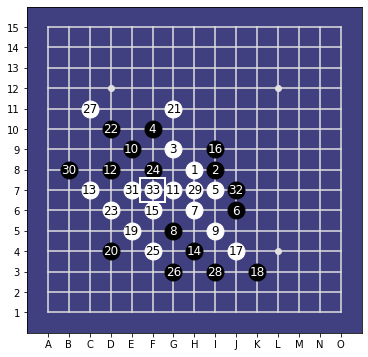

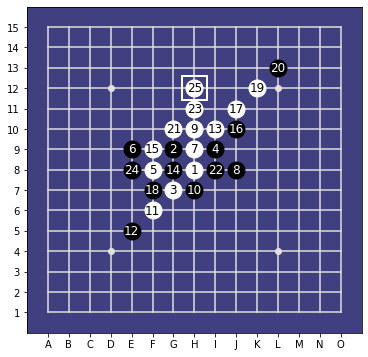

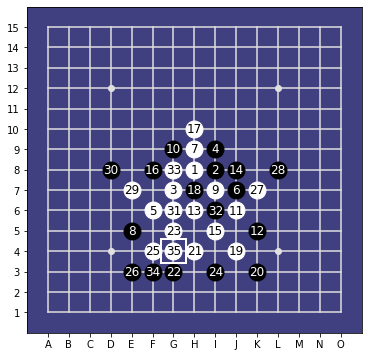

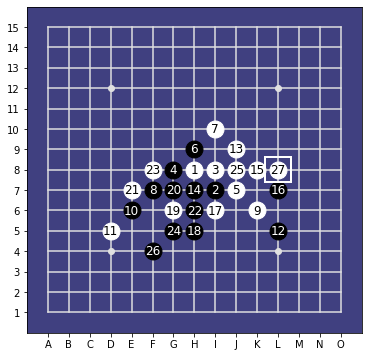

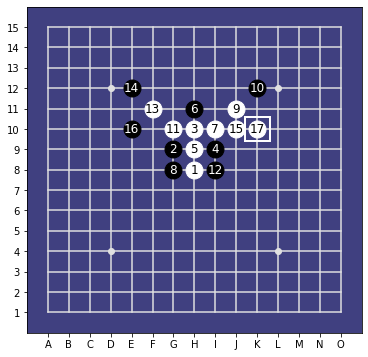

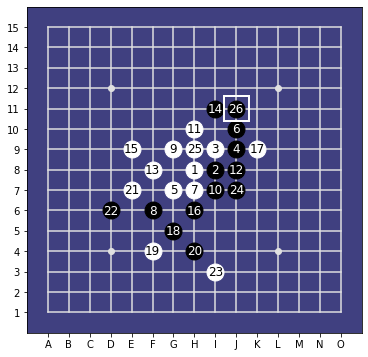

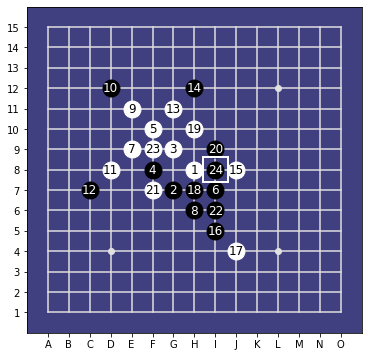

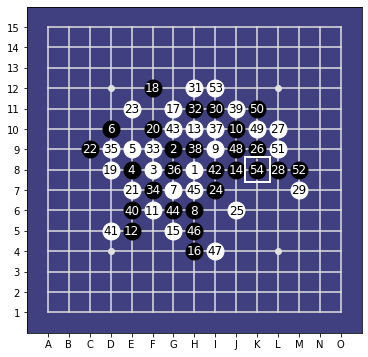

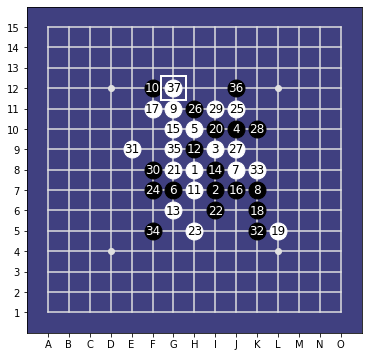

In [66]:

for i in range(9):
    GomokuBoard(15, stones=rounds[-1][i]).display()